In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch_3d as smp
from unittest.mock import patch
from scipy.ndimage import gaussian_filter
from timm.layers import LayerNorm2d, LayerNorm
from medpy.io import load

from src.utils.convert_2d_to_3d import patch_first_conv, convert_2d_to_3d, TimmUniversalEncoder3d

/root/miniconda3/envs/aorta/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Convert 2D to 3D

## Toy idea illustration

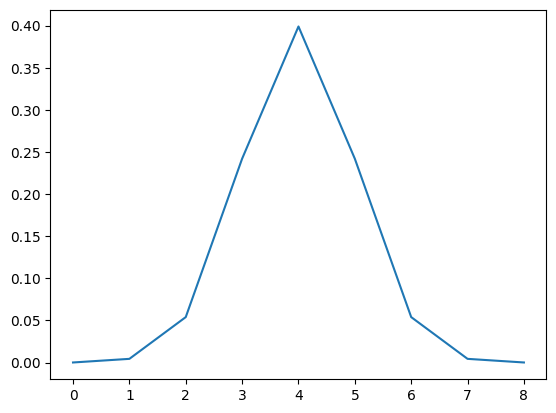

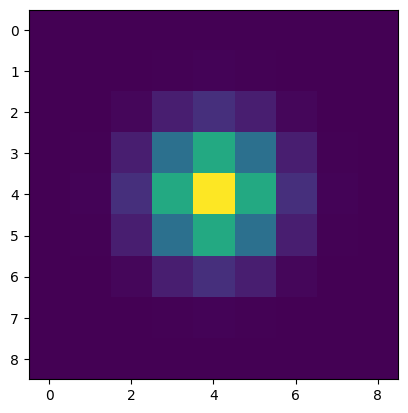

In [5]:
gauss = gaussian_filter(np.float_([0,0,0,0,1,0,0,0,0]), 1)
plt.figure()
plt.plot(gauss)
plt.figure()
plt.imshow(gauss[:, None] * gauss[None, :])

## Model conversion

In [6]:
model = timm.create_model('convnextv2_nano.fcmae_ft_in22k_in1k_384', features_only=True, pretrained=True).cuda()
patch_first_conv(model, 1)
model

FeatureListNet(
  (stem_0): Conv2d(1, 80, kernel_size=(4, 4), stride=(4, 4))
  (stem_1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
  (stages_0): ConvNeXtStage(
    (downsample): Identity()
    (blocks): Sequential(
      (0): ConvNeXtBlock(
        (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
        (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
        (mlp): GlobalResponseNormMlp(
          (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (grn): GlobalResponseNorm()
          (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (shortcut): Identity()
        (drop_path): Identity()
      )
      (1): ConvNeXtBlock(
        (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
        (norm): LayerNorm2d((80,), eps=1e-

In [7]:
x = torch.randn(1, 1, 64, 64, 64).cuda()

In [8]:
with torch.no_grad():
    print([f.shape for f in model(x[..., 0])])

[torch.Size([1, 80, 16, 16]), torch.Size([1, 160, 8, 8]), torch.Size([1, 320, 4, 4]), torch.Size([1, 640, 2, 2])]


In [9]:
[line for line in str(model).split('\n') if '2d' in line]

['  (stem_0): Conv2d(1, 80, kernel_size=(4, 4), stride=(4, 4))',
 '  (stem_1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)',
 '        (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)',
 '        (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)',
 '          (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))',
 '          (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))',
 '        (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)',
 '        (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)',
 '          (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))',
 '          (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))',
 '      (0): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)',
 '      (1): Conv2d(80, 160, kernel_size=(2, 2), stride=(2, 2))',
 '        (conv_dw): Conv2d(160, 160, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [10]:
for layer_name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print('c2d', layer.weight.shape, layer.bias.shape)
        assert layer.weight.shape[-1] == layer.weight.shape[-2]
    elif isinstance(layer, LayerNorm2d):
        print('ln2d', layer.weight.shape, layer.bias.shape)
    elif isinstance(layer, LayerNorm):
        print('ln', layer.weight.shape, layer.bias.shape)

c2d torch.Size([80, 1, 4, 4]) torch.Size([80])
ln2d torch.Size([80]) torch.Size([80])
c2d torch.Size([80, 1, 7, 7]) torch.Size([80])
ln2d torch.Size([80]) torch.Size([80])
c2d torch.Size([320, 80, 1, 1]) torch.Size([320])
c2d torch.Size([80, 320, 1, 1]) torch.Size([80])
c2d torch.Size([80, 1, 7, 7]) torch.Size([80])
ln2d torch.Size([80]) torch.Size([80])
c2d torch.Size([320, 80, 1, 1]) torch.Size([320])
c2d torch.Size([80, 320, 1, 1]) torch.Size([80])
ln2d torch.Size([80]) torch.Size([80])
c2d torch.Size([160, 80, 2, 2]) torch.Size([160])
c2d torch.Size([160, 1, 7, 7]) torch.Size([160])
ln2d torch.Size([160]) torch.Size([160])
c2d torch.Size([640, 160, 1, 1]) torch.Size([640])
c2d torch.Size([160, 640, 1, 1]) torch.Size([160])
c2d torch.Size([160, 1, 7, 7]) torch.Size([160])
ln2d torch.Size([160]) torch.Size([160])
c2d torch.Size([640, 160, 1, 1]) torch.Size([640])
c2d torch.Size([160, 640, 1, 1]) torch.Size([160])
ln2d torch.Size([160]) torch.Size([160])
c2d torch.Size([320, 160, 2, 2

In [11]:
c3d = nn.Conv3d(3, 96, 4)
c3d.weight.shape, c3d.bias.shape

(torch.Size([96, 3, 4, 4, 4]), torch.Size([96]))

In [12]:
for layer_name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print('c2d', layer.weight.shape, layer.bias.shape)
        assert layer.weight.shape[-1] == layer.weight.shape[-2]
        break
layer

c2d torch.Size([80, 1, 4, 4]) torch.Size([80])


Conv2d(1, 80, kernel_size=(4, 4), stride=(4, 4))

In [13]:
layer.weight.shape

torch.Size([80, 1, 4, 4])

In [14]:
(
    layer.weight[..., None, :, :] + 
    layer.weight[..., :, None, :] + 
    layer.weight[..., :, :, None]
).shape

torch.Size([80, 1, 4, 4, 4])

In [15]:
c3d.weight.shape

torch.Size([96, 3, 4, 4, 4])

In [16]:
convert_2d_to_3d(model)
model

FeatureListNet(
  (stem_0): Conv3d(1, 80, kernel_size=(4, 4, 4), stride=(4, 4, 4))
  (stem_1): LayerNorm3d((80,), eps=1e-06, elementwise_affine=True)
  (stages_0): ConvNeXtStage(
    (downsample): Identity()
    (blocks): Sequential(
      (0): ConvNeXtBlock(
        (conv_dw): Conv3d(80, 80, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), groups=80)
        (norm): LayerNorm3d((80,), eps=1e-06, elementwise_affine=True)
        (mlp): GlobalResponseNormMlp(
          (fc1): Conv3d(80, 320, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (grn): GlobalResponseNorm3d()
          (fc2): Conv3d(320, 80, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (shortcut): Identity()
        (drop_path): Identity()
      )
      (1): ConvNeXtBlock(
        (conv_dw): Conv3d(80, 80, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), groups=80)
    

In [17]:
[line for line in str(model).split('\n') if '2d' in line]

[]

In [19]:
with torch.no_grad():
    output = model(x)
print([f.shape for f in output])

[torch.Size([1, 80, 16, 16, 16]), torch.Size([1, 160, 8, 8, 8]), torch.Size([1, 320, 4, 4, 4]), torch.Size([1, 640, 2, 2, 2])]


In [20]:
len(output)

4

## Usage with SMP 3D

In [3]:
with patch('segmentation_models_pytorch_3d.encoders.TimmUniversalEncoder', TimmUniversalEncoder3d):
    model_seg = smp.Unet(
        encoder_name='tu-convnextv2_nano.fcmae_ft_in22k_in1k_384',
        in_channels=1,
        classes=3,
        encoder_depth=4,
        decoder_channels=(256, 128, 64, 32),
        strides=((4, 4, 4), (2, 2, 2), (2, 2, 2), (2, 2, 2)),
    ).cuda()

In [4]:
x = torch.randn(1, 1, 64, 64, 64).cuda()

In [5]:
model_seg(x).shape

torch.Size([1, 3, 64, 64, 64])

In [6]:
[f.shape for f in model_seg.encoder(x)]

[torch.Size([1, 1, 64, 64, 64]),
 torch.Size([1, 80, 16, 16, 16]),
 torch.Size([1, 160, 8, 8, 8]),
 torch.Size([1, 320, 4, 4, 4]),
 torch.Size([1, 640, 2, 2, 2])]